In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import time
import copy
import os

In [2]:
batch_size = 64
learning_rate = 0.0001

transforms = transforms.Compose(
[
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(root='emotion_FixedVer_TrainTest/train/', transform=transforms)
test_dataset = datasets.ImageFolder(root='emotion_FixedVer_TrainTest/test/', transform=transforms)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
def imshow(inp, title=None):
    
    inp = inp.cpu() if device else inp
    inp = inp.numpy().transpose((1, 2, 0))
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

images-size: torch.Size([64, 3, 48, 48])
out-size: torch.Size([3, 402, 402])


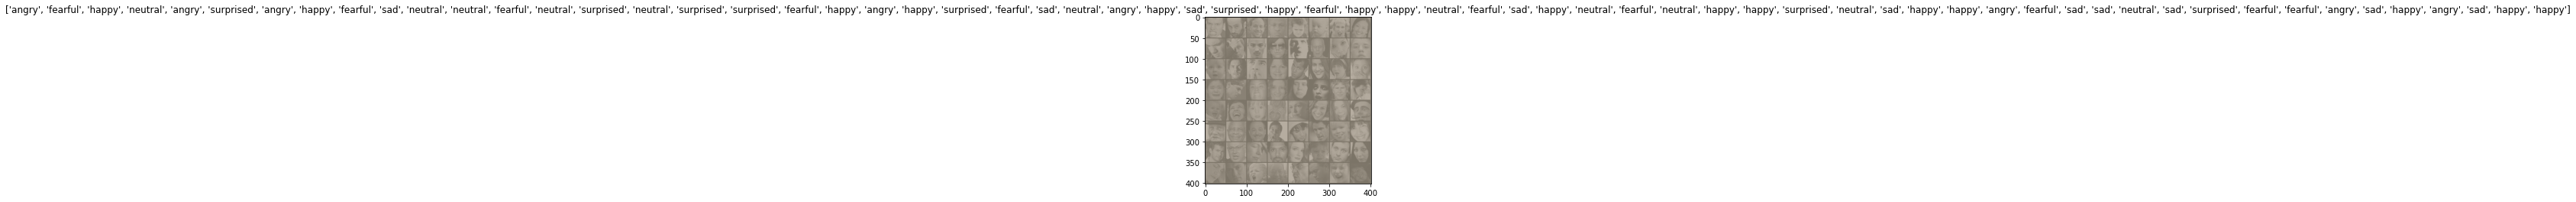

In [4]:
images, labels = next(iter(train_dataloader)) 
print("images-size:", images.shape)

out = torchvision.utils.make_grid(images)
print("out-size:", out.shape)

imshow(out, title=[train_dataset.classes[x] for x in labels])

In [5]:
net = models.resnet50(pretrained=True)
net = net.cuda() if device else net
net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001, 
                 betas=(0.9, 0.999), 
                 eps=1e-08, 
                 weight_decay=0, 
                 amsgrad=False)

def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 48)
net.fc = net.fc.cuda() if device else net.fc

In [7]:
n_epochs = 100
print_every = 10
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_dataloader)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_dataloader):
        data_, target_ = data_.to(device), target_.to(device)
        optimizer.zero_grad()
        
        outputs = net(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        net.eval()
        for data_t, target_t in (test_dataloader):
            data_t, target_t = data_t.to(device), target_t.to(device)
            outputs_t = net(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(test_dataloader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')

        
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(net.state_dict(), 'resnet_adam_batch64_lr00001_nnlinear48_learning00001.pt')
            print('Improvement-Detected, save-model')
    net.train()

Epoch 1

Epoch [1/100], Step [0/312], Loss: 3.8695
Epoch [1/100], Step [20/312], Loss: 3.4400
Epoch [1/100], Step [40/312], Loss: 2.8787
Epoch [1/100], Step [60/312], Loss: 2.1960
Epoch [1/100], Step [80/312], Loss: 2.2447
Epoch [1/100], Step [100/312], Loss: 1.6717
Epoch [1/100], Step [120/312], Loss: 1.9849
Epoch [1/100], Step [140/312], Loss: 1.7571
Epoch [1/100], Step [160/312], Loss: 1.5631
Epoch [1/100], Step [180/312], Loss: 1.4241
Epoch [1/100], Step [200/312], Loss: 1.7024
Epoch [1/100], Step [220/312], Loss: 1.3435
Epoch [1/100], Step [240/312], Loss: 1.5182
Epoch [1/100], Step [260/312], Loss: 1.9525
Epoch [1/100], Step [280/312], Loss: 1.4130
Epoch [1/100], Step [300/312], Loss: 1.7471

train-loss: 1.9478, train-acc: 47.1743
validation loss: 1.3368, validation acc: 56.5250

Improvement-Detected, save-model
Epoch 2

Epoch [2/100], Step [0/312], Loss: 1.2117
Epoch [2/100], Step [20/312], Loss: 1.0279
Epoch [2/100], Step [40/312], Loss: 1.0531
Epoch [2/100], Step [60/312], Los

Epoch [11/100], Step [60/312], Loss: 0.1096
Epoch [11/100], Step [80/312], Loss: 0.0341
Epoch [11/100], Step [100/312], Loss: 0.1316
Epoch [11/100], Step [120/312], Loss: 0.0433
Epoch [11/100], Step [140/312], Loss: 0.0460
Epoch [11/100], Step [160/312], Loss: 0.1214
Epoch [11/100], Step [180/312], Loss: 0.1395
Epoch [11/100], Step [200/312], Loss: 0.2048
Epoch [11/100], Step [220/312], Loss: 0.1168
Epoch [11/100], Step [240/312], Loss: 0.1142
Epoch [11/100], Step [260/312], Loss: 0.0824
Epoch [11/100], Step [280/312], Loss: 0.1347
Epoch [11/100], Step [300/312], Loss: 0.0786

train-loss: 0.4967, train-acc: 96.8387
validation loss: 1.6007, validation acc: 61.7223

Epoch 12

Epoch [12/100], Step [0/312], Loss: 0.0899
Epoch [12/100], Step [20/312], Loss: 0.0522
Epoch [12/100], Step [40/312], Loss: 0.0547
Epoch [12/100], Step [60/312], Loss: 0.0880
Epoch [12/100], Step [80/312], Loss: 0.1108
Epoch [12/100], Step [100/312], Loss: 0.0649
Epoch [12/100], Step [120/312], Loss: 0.0346
Epoch [1

Epoch [21/100], Step [100/312], Loss: 0.0044
Epoch [21/100], Step [120/312], Loss: 0.0690
Epoch [21/100], Step [140/312], Loss: 0.0112
Epoch [21/100], Step [160/312], Loss: 0.0244
Epoch [21/100], Step [180/312], Loss: 0.0119
Epoch [21/100], Step [200/312], Loss: 0.0864
Epoch [21/100], Step [220/312], Loss: 0.0314
Epoch [21/100], Step [240/312], Loss: 0.0637
Epoch [21/100], Step [260/312], Loss: 0.1005
Epoch [21/100], Step [280/312], Loss: 0.1353
Epoch [21/100], Step [300/312], Loss: 0.1129

train-loss: 0.2974, train-acc: 97.9259
validation loss: 1.8144, validation acc: 62.3166

Epoch 22

Epoch [22/100], Step [0/312], Loss: 0.0769
Epoch [22/100], Step [20/312], Loss: 0.0605
Epoch [22/100], Step [40/312], Loss: 0.0134
Epoch [22/100], Step [60/312], Loss: 0.0240
Epoch [22/100], Step [80/312], Loss: 0.1672
Epoch [22/100], Step [100/312], Loss: 0.0973
Epoch [22/100], Step [120/312], Loss: 0.0362
Epoch [22/100], Step [140/312], Loss: 0.0158
Epoch [22/100], Step [160/312], Loss: 0.0188
Epoch 

Epoch [31/100], Step [140/312], Loss: 0.0301
Epoch [31/100], Step [160/312], Loss: 0.0962
Epoch [31/100], Step [180/312], Loss: 0.0241
Epoch [31/100], Step [200/312], Loss: 0.0181
Epoch [31/100], Step [220/312], Loss: 0.0075
Epoch [31/100], Step [240/312], Loss: 0.0278
Epoch [31/100], Step [260/312], Loss: 0.0233
Epoch [31/100], Step [280/312], Loss: 0.0363
Epoch [31/100], Step [300/312], Loss: 0.0501

train-loss: 0.2185, train-acc: 98.3667
validation loss: 1.9238, validation acc: 63.0627

Epoch 32

Epoch [32/100], Step [0/312], Loss: 0.0638
Epoch [32/100], Step [20/312], Loss: 0.0282
Epoch [32/100], Step [40/312], Loss: 0.0109
Epoch [32/100], Step [60/312], Loss: 0.0647
Epoch [32/100], Step [80/312], Loss: 0.0679
Epoch [32/100], Step [100/312], Loss: 0.0526
Epoch [32/100], Step [120/312], Loss: 0.1099
Epoch [32/100], Step [140/312], Loss: 0.0325
Epoch [32/100], Step [160/312], Loss: 0.0210
Epoch [32/100], Step [180/312], Loss: 0.0336
Epoch [32/100], Step [200/312], Loss: 0.0064
Epoch 

Epoch [41/100], Step [180/312], Loss: 0.0116
Epoch [41/100], Step [200/312], Loss: 0.0224
Epoch [41/100], Step [220/312], Loss: 0.1496
Epoch [41/100], Step [240/312], Loss: 0.0184
Epoch [41/100], Step [260/312], Loss: 0.1059
Epoch [41/100], Step [280/312], Loss: 0.1581
Epoch [41/100], Step [300/312], Loss: 0.0131

train-loss: 0.1755, train-acc: 98.7124
validation loss: 2.0021, validation acc: 61.9752

Epoch 42

Epoch [42/100], Step [0/312], Loss: 0.0171
Epoch [42/100], Step [20/312], Loss: 0.1170
Epoch [42/100], Step [40/312], Loss: 0.0741
Epoch [42/100], Step [60/312], Loss: 0.0316
Epoch [42/100], Step [80/312], Loss: 0.0490
Epoch [42/100], Step [100/312], Loss: 0.0105
Epoch [42/100], Step [120/312], Loss: 0.0154
Epoch [42/100], Step [140/312], Loss: 0.0071
Epoch [42/100], Step [160/312], Loss: 0.0442
Epoch [42/100], Step [180/312], Loss: 0.0551
Epoch [42/100], Step [200/312], Loss: 0.0018
Epoch [42/100], Step [220/312], Loss: 0.0323
Epoch [42/100], Step [240/312], Loss: 0.0424
Epoch 

Epoch [51/100], Step [220/312], Loss: 0.0085
Epoch [51/100], Step [240/312], Loss: 0.0066
Epoch [51/100], Step [260/312], Loss: 0.0039
Epoch [51/100], Step [280/312], Loss: 0.0067
Epoch [51/100], Step [300/312], Loss: 0.0194

train-loss: 0.1479, train-acc: 98.9579
validation loss: 2.0493, validation acc: 62.2408

Epoch 52

Epoch [52/100], Step [0/312], Loss: 0.1023
Epoch [52/100], Step [20/312], Loss: 0.0307
Epoch [52/100], Step [40/312], Loss: 0.0070
Epoch [52/100], Step [60/312], Loss: 0.0064
Epoch [52/100], Step [80/312], Loss: 0.0061
Epoch [52/100], Step [100/312], Loss: 0.0234
Epoch [52/100], Step [120/312], Loss: 0.0109
Epoch [52/100], Step [140/312], Loss: 0.0591
Epoch [52/100], Step [160/312], Loss: 0.0069
Epoch [52/100], Step [180/312], Loss: 0.0025
Epoch [52/100], Step [200/312], Loss: 0.0236
Epoch [52/100], Step [220/312], Loss: 0.0087
Epoch [52/100], Step [240/312], Loss: 0.0020
Epoch [52/100], Step [260/312], Loss: 0.0041
Epoch [52/100], Step [280/312], Loss: 0.0345
Epoch 

Epoch [61/100], Step [260/312], Loss: 0.0266
Epoch [61/100], Step [280/312], Loss: 0.0046
Epoch [61/100], Step [300/312], Loss: 0.0205

train-loss: 0.1286, train-acc: 99.0631
validation loss: 2.0891, validation acc: 62.7972

Epoch 62

Epoch [62/100], Step [0/312], Loss: 0.0721
Epoch [62/100], Step [20/312], Loss: 0.0850
Epoch [62/100], Step [40/312], Loss: 0.0455
Epoch [62/100], Step [60/312], Loss: 0.0089
Epoch [62/100], Step [80/312], Loss: 0.0073
Epoch [62/100], Step [100/312], Loss: 0.0135
Epoch [62/100], Step [120/312], Loss: 0.0013
Epoch [62/100], Step [140/312], Loss: 0.0243
Epoch [62/100], Step [160/312], Loss: 0.0689
Epoch [62/100], Step [180/312], Loss: 0.0040
Epoch [62/100], Step [200/312], Loss: 0.0024
Epoch [62/100], Step [220/312], Loss: 0.0443
Epoch [62/100], Step [240/312], Loss: 0.0548
Epoch [62/100], Step [260/312], Loss: 0.0412
Epoch [62/100], Step [280/312], Loss: 0.0328
Epoch [62/100], Step [300/312], Loss: 0.0457

train-loss: 0.1270, train-acc: 99.0331
validation 

Epoch [71/100], Step [300/312], Loss: 0.0073

train-loss: 0.1142, train-acc: 99.2836
validation loss: 2.1237, validation acc: 63.4041

Epoch 72

Epoch [72/100], Step [0/312], Loss: 0.0023
Epoch [72/100], Step [20/312], Loss: 0.0112
Epoch [72/100], Step [40/312], Loss: 0.0044
Epoch [72/100], Step [60/312], Loss: 0.0016
Epoch [72/100], Step [80/312], Loss: 0.0009
Epoch [72/100], Step [100/312], Loss: 0.0648
Epoch [72/100], Step [120/312], Loss: 0.0058
Epoch [72/100], Step [140/312], Loss: 0.0075
Epoch [72/100], Step [160/312], Loss: 0.0417
Epoch [72/100], Step [180/312], Loss: 0.0317
Epoch [72/100], Step [200/312], Loss: 0.0147
Epoch [72/100], Step [220/312], Loss: 0.0120
Epoch [72/100], Step [240/312], Loss: 0.0159
Epoch [72/100], Step [260/312], Loss: 0.0195
Epoch [72/100], Step [280/312], Loss: 0.0056
Epoch [72/100], Step [300/312], Loss: 0.0304

train-loss: 0.1129, train-acc: 99.2134
validation loss: 2.1268, validation acc: 63.1133

Epoch 73

Epoch [73/100], Step [0/312], Loss: 0.001

validation loss: 2.1493, validation acc: 63.5306

Epoch 82

Epoch [82/100], Step [0/312], Loss: 0.0235
Epoch [82/100], Step [20/312], Loss: 0.0207
Epoch [82/100], Step [40/312], Loss: 0.0181
Epoch [82/100], Step [60/312], Loss: 0.0023
Epoch [82/100], Step [80/312], Loss: 0.0029
Epoch [82/100], Step [100/312], Loss: 0.0148
Epoch [82/100], Step [120/312], Loss: 0.0060
Epoch [82/100], Step [140/312], Loss: 0.0302
Epoch [82/100], Step [160/312], Loss: 0.0481
Epoch [82/100], Step [180/312], Loss: 0.0134
Epoch [82/100], Step [200/312], Loss: 0.0252
Epoch [82/100], Step [220/312], Loss: 0.0382
Epoch [82/100], Step [240/312], Loss: 0.0164
Epoch [82/100], Step [260/312], Loss: 0.0038
Epoch [82/100], Step [280/312], Loss: 0.0234
Epoch [82/100], Step [300/312], Loss: 0.0289

train-loss: 0.1021, train-acc: 99.1383
validation loss: 2.1515, validation acc: 63.1259

Epoch 83

Epoch [83/100], Step [0/312], Loss: 0.0027
Epoch [83/100], Step [20/312], Loss: 0.0022
Epoch [83/100], Step [40/312], Loss: 0.

Epoch [92/100], Step [20/312], Loss: 0.0018
Epoch [92/100], Step [40/312], Loss: 0.0039
Epoch [92/100], Step [60/312], Loss: 0.0194
Epoch [92/100], Step [80/312], Loss: 0.0795
Epoch [92/100], Step [100/312], Loss: 0.0041
Epoch [92/100], Step [120/312], Loss: 0.0031
Epoch [92/100], Step [140/312], Loss: 0.0845
Epoch [92/100], Step [160/312], Loss: 0.0619
Epoch [92/100], Step [180/312], Loss: 0.0037
Epoch [92/100], Step [200/312], Loss: 0.0164
Epoch [92/100], Step [220/312], Loss: 0.0446
Epoch [92/100], Step [240/312], Loss: 0.0085
Epoch [92/100], Step [260/312], Loss: 0.0047
Epoch [92/100], Step [280/312], Loss: 0.0077
Epoch [92/100], Step [300/312], Loss: 0.0115

train-loss: 0.0933, train-acc: 98.9780
validation loss: 2.1762, validation acc: 63.1765

Epoch 93

Epoch [93/100], Step [0/312], Loss: 0.0774
Epoch [93/100], Step [20/312], Loss: 0.0022
Epoch [93/100], Step [40/312], Loss: 0.0177
Epoch [93/100], Step [60/312], Loss: 0.0009
Epoch [93/100], Step [80/312], Loss: 0.0212
Epoch [93/

In [8]:
for i in range(len(train_acc)):
    train_acc[i] = train_acc[i] / 100
for i in range(len(val_acc)):
    val_acc[i] = val_acc[i] / 100


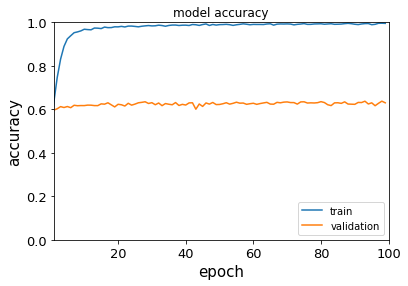

In [9]:
fig = plt.title("model accuracy")
plt.plot(train_acc)
plt.plot(val_acc)
plt.axis([1, 100, 0, 1])
plt.ylabel("accuracy", fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel("epoch", fontsize=15)
plt.legend(["train", "validation"], loc="lower right")
plt.show()